In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
plt.rcParams['figure.facecolor'] = 'white'

from numba import jit

In [173]:
def gather_universal(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(filetype) and name[-5]!='t'  :

                b=(str(os.path.join(path, name)))
                data.append(b)

                #print (str(os.path.join(path, name)))
    return data
def sort_on_last(list:list)->list:
    df=pd.DataFrame({'list': list})
    df['nums']=df['list'].apply(lambda x:x.split('_')[-1].split('.')[0])
    df['nums']=df.nums.astype(int)
    df.sort_values(by='nums',inplace=True)
    #display(df)
    return(np.array(df['list']))
@jit(nopython=True)
def clean_file(file):
        for num,line in enumerate(file):

            a=line.replace(',','.')
            a=a.replace('e-00','e-')
            a=a.replace('e-0','e-')
            a=a.replace('\n','')
            a=a.replace('\t\t\t\t','\t\t')
            file[num]=a


        return file
@jit(nopython=True)
def get_col_unit(file):
        cols=file[1].split('\t')
        units=file[2].split('\t')

        col_unit=[]
        for i,v in enumerate(cols):
            col_unit.append(v+' ['+units[i]+']')
        return(col_unit)
@jit(nopython=False)
def split_file(file,col_unit):
        splitfile=np.array(col_unit)
        for line in np.arange(3,len(file)):
            a=np.array(file[line].split('\t'),dtype=str)
            splitfile=np.vstack((splitfile,a))
        return(splitfile)
@jit(nopython=True)
def get_file(path)->list:

        file=[]
        with open(path, 'r') as reader:
             # Read and print the entire file line by line
            for line in reader:
                file.append(line)
        return(file)
def get_force(path):
    with open(path, 'r') as reader:
        lines=reader.readlines()[:4]

        #head = [next(reader) for x in range(4)]
        #display(head)


        #display(lines[3])
        force=lines[3].split('\t')[-2].split('\n')[0].replace(',','.')
        return float(force)

def get_header(path)->list:
    with open(path, 'r') as reader:
        lines=reader.readlines()
        cleanline1=lines[1].replace('\n','').replace('\t\t\t\t','\t').split('\t')
        cleanline2=lines[2].replace('\n','').replace('\t\t\t\t','\t').split('\t')
        #display(len(cleanline2),len(cleanline1))
        col_unit=[]
        for i,v in enumerate(cleanline1):
            col_unit.append(v+' ['+cleanline2[i]+']')
        #display(col_unit)
        return(col_unit[:])

#get_header('data/MC_A6yii/Step_149.txt')
def manual_input(path:str)->pd.DataFrame:

    file=get_file(path)        #print(line, end='')
    file=clean_file(file)

    col_unit=get_col_unit(file)

    splitfile=split_file(file,col_unit)
    df=pd.DataFrame(data=splitfile[1:,:],columns=splitfile[0,:])
    display(df)
    df[df=='']=np.nan
    df=df.astype(np.float64)
    #%%
    display(df.columns)

    f=df.loc[:,['x []','y []','strains [strain_p1/strain]']]
    b=f.pivot(index='y []',columns='x []',values='strains [strain_p1/strain]')
    display(b)
    #%%
    plt.matshow(b)

In [174]:
def cleaner(filepath,exportnames):
    fin = open(filepath, "rt")
    #read file contents to string
    data = fin.read()
    #replace all occurrences of the required string
    data = data.replace('\t\t\t\t', '\t\t')
    data = data.replace('e-00', 'e-')
    data = data.replace('e-0', 'e-')
    data = data.replace('e+00', 'e+')
    data = data.replace('e+0', 'e+')
    data = data.replace('.', '')
    data = data.replace(',', '.')
    #close the input file
    fin.close()
    #open the input file in write mode
    fin = open(exportnames[filepath], "wt")
    #overrite the input file with the resulting data
    fin.write(data)
    #close the file
    fin.close()
def auto_input(path:str)->pd.DataFrame:

    df=pd.read_csv(path,header=None,skiprows=range(3),sep='\t',decimal='.',encoding='utf-8')

    df.columns=get_header(path)
    df.set_index(['x []','y []'],inplace=True)

    #display(df)
    return df


In [175]:
def get_p1(df):
    p1=df['strains [true_strain_p1/strain]'].reset_index().pivot(index='x []',columns='y []',values='strains [true_strain_p1/strain]').copy()
    return(p1)
def meanofslice(df):
    horizontalcount=10
    horizontalsize=int(len(df.columns)/horizontalcount)
    verticalsize=len(df.index)
    #display(horizontalsize,verticalsize)
    res=np.zeros(horizontalcount)
    #display(res)
    for i in range(horizontalcount):
        start=i*horizontalsize
        end=((i*horizontalsize)+horizontalsize)
        res[i]=np.nanmean(np.array(df.iloc[:,start:end]))
        #display(res[i])
        #display(i,df.iloc[:,start:end])
        #res[i]=np.mean(df.iloc[:,start:end])
    return(res)


In [225]:
names=sort_on_last(gather_universal('data/MC_B_6xii','.txt'))
def amend_export(string):
    return string.split('.')[0]+'_export.txt'
#display(names)
exportnames={i:amend_export(i) for i in names}
#display(exportnames)

res=[]
force=[]
for name in names:
    force.append(get_force(name))
    #display(get_force(name))
    cleaner(name,exportnames)
    df=auto_input(exportnames[name])
    display(exportnames[name])
    p1=get_p1(df)
    meanarr=meanofslice(p1)
    res.append(meanarr)

ap=pd.DataFrame(res)
display(ap)
#display(force)

'data/MC_B_6xii\\Step_0_export.txt'

'data/MC_B_6xii\\Step_1_export.txt'

'data/MC_B_6xii\\Step_2_export.txt'

'data/MC_B_6xii\\Step_3_export.txt'

'data/MC_B_6xii\\Step_4_export.txt'

'data/MC_B_6xii\\Step_5_export.txt'

'data/MC_B_6xii\\Step_6_export.txt'

'data/MC_B_6xii\\Step_7_export.txt'

'data/MC_B_6xii\\Step_8_export.txt'

'data/MC_B_6xii\\Step_9_export.txt'

'data/MC_B_6xii\\Step_10_export.txt'

'data/MC_B_6xii\\Step_11_export.txt'

'data/MC_B_6xii\\Step_12_export.txt'

'data/MC_B_6xii\\Step_13_export.txt'

'data/MC_B_6xii\\Step_14_export.txt'

'data/MC_B_6xii\\Step_15_export.txt'

'data/MC_B_6xii\\Step_16_export.txt'

'data/MC_B_6xii\\Step_17_export.txt'

'data/MC_B_6xii\\Step_18_export.txt'

'data/MC_B_6xii\\Step_19_export.txt'

'data/MC_B_6xii\\Step_20_export.txt'

'data/MC_B_6xii\\Step_21_export.txt'

'data/MC_B_6xii\\Step_22_export.txt'

'data/MC_B_6xii\\Step_23_export.txt'

'data/MC_B_6xii\\Step_24_export.txt'

'data/MC_B_6xii\\Step_25_export.txt'

'data/MC_B_6xii\\Step_26_export.txt'

'data/MC_B_6xii\\Step_27_export.txt'

'data/MC_B_6xii\\Step_28_export.txt'

'data/MC_B_6xii\\Step_29_export.txt'

'data/MC_B_6xii\\Step_30_export.txt'

'data/MC_B_6xii\\Step_31_export.txt'

'data/MC_B_6xii\\Step_32_export.txt'

'data/MC_B_6xii\\Step_33_export.txt'

'data/MC_B_6xii\\Step_34_export.txt'

'data/MC_B_6xii\\Step_35_export.txt'

'data/MC_B_6xii\\Step_36_export.txt'

'data/MC_B_6xii\\Step_37_export.txt'

'data/MC_B_6xii\\Step_38_export.txt'

'data/MC_B_6xii\\Step_39_export.txt'

'data/MC_B_6xii\\Step_40_export.txt'

'data/MC_B_6xii\\Step_41_export.txt'

'data/MC_B_6xii\\Step_42_export.txt'

'data/MC_B_6xii\\Step_43_export.txt'

'data/MC_B_6xii\\Step_44_export.txt'

'data/MC_B_6xii\\Step_45_export.txt'

'data/MC_B_6xii\\Step_46_export.txt'

'data/MC_B_6xii\\Step_47_export.txt'

'data/MC_B_6xii\\Step_48_export.txt'

'data/MC_B_6xii\\Step_49_export.txt'

'data/MC_B_6xii\\Step_50_export.txt'

'data/MC_B_6xii\\Step_51_export.txt'

'data/MC_B_6xii\\Step_52_export.txt'

'data/MC_B_6xii\\Step_53_export.txt'

'data/MC_B_6xii\\Step_54_export.txt'

'data/MC_B_6xii\\Step_55_export.txt'

'data/MC_B_6xii\\Step_56_export.txt'

'data/MC_B_6xii\\Step_57_export.txt'

'data/MC_B_6xii\\Step_58_export.txt'

'data/MC_B_6xii\\Step_59_export.txt'

'data/MC_B_6xii\\Step_60_export.txt'

'data/MC_B_6xii\\Step_61_export.txt'

'data/MC_B_6xii\\Step_62_export.txt'

'data/MC_B_6xii\\Step_63_export.txt'

'data/MC_B_6xii\\Step_64_export.txt'

'data/MC_B_6xii\\Step_65_export.txt'

'data/MC_B_6xii\\Step_66_export.txt'

'data/MC_B_6xii\\Step_67_export.txt'

'data/MC_B_6xii\\Step_68_export.txt'

'data/MC_B_6xii\\Step_69_export.txt'

'data/MC_B_6xii\\Step_70_export.txt'

'data/MC_B_6xii\\Step_71_export.txt'

'data/MC_B_6xii\\Step_72_export.txt'

'data/MC_B_6xii\\Step_73_export.txt'

'data/MC_B_6xii\\Step_74_export.txt'

'data/MC_B_6xii\\Step_75_export.txt'

'data/MC_B_6xii\\Step_76_export.txt'

'data/MC_B_6xii\\Step_77_export.txt'

'data/MC_B_6xii\\Step_78_export.txt'

'data/MC_B_6xii\\Step_79_export.txt'

'data/MC_B_6xii\\Step_80_export.txt'

'data/MC_B_6xii\\Step_81_export.txt'

'data/MC_B_6xii\\Step_82_export.txt'

'data/MC_B_6xii\\Step_83_export.txt'

'data/MC_B_6xii\\Step_84_export.txt'

'data/MC_B_6xii\\Step_85_export.txt'

'data/MC_B_6xii\\Step_86_export.txt'

'data/MC_B_6xii\\Step_87_export.txt'

'data/MC_B_6xii\\Step_88_export.txt'

'data/MC_B_6xii\\Step_89_export.txt'

'data/MC_B_6xii\\Step_90_export.txt'

'data/MC_B_6xii\\Step_91_export.txt'

'data/MC_B_6xii\\Step_92_export.txt'

'data/MC_B_6xii\\Step_93_export.txt'

'data/MC_B_6xii\\Step_94_export.txt'

'data/MC_B_6xii\\Step_95_export.txt'

'data/MC_B_6xii\\Step_96_export.txt'

'data/MC_B_6xii\\Step_97_export.txt'

'data/MC_B_6xii\\Step_98_export.txt'

'data/MC_B_6xii\\Step_99_export.txt'

'data/MC_B_6xii\\Step_100_export.txt'

'data/MC_B_6xii\\Step_101_export.txt'

'data/MC_B_6xii\\Step_102_export.txt'

'data/MC_B_6xii\\Step_103_export.txt'

'data/MC_B_6xii\\Step_104_export.txt'

'data/MC_B_6xii\\Step_105_export.txt'

'data/MC_B_6xii\\Step_106_export.txt'

'data/MC_B_6xii\\Step_107_export.txt'

'data/MC_B_6xii\\Step_108_export.txt'

'data/MC_B_6xii\\Step_109_export.txt'

'data/MC_B_6xii\\Step_110_export.txt'

'data/MC_B_6xii\\Step_111_export.txt'

'data/MC_B_6xii\\Step_112_export.txt'

'data/MC_B_6xii\\Step_113_export.txt'

'data/MC_B_6xii\\Step_114_export.txt'

'data/MC_B_6xii\\Step_115_export.txt'

'data/MC_B_6xii\\Step_116_export.txt'

'data/MC_B_6xii\\Step_117_export.txt'

'data/MC_B_6xii\\Step_118_export.txt'

'data/MC_B_6xii\\Step_119_export.txt'

'data/MC_B_6xii\\Step_120_export.txt'

'data/MC_B_6xii\\Step_121_export.txt'

'data/MC_B_6xii\\Step_122_export.txt'

'data/MC_B_6xii\\Step_123_export.txt'

'data/MC_B_6xii\\Step_124_export.txt'

'data/MC_B_6xii\\Step_125_export.txt'

'data/MC_B_6xii\\Step_126_export.txt'

'data/MC_B_6xii\\Step_127_export.txt'

'data/MC_B_6xii\\Step_128_export.txt'

'data/MC_B_6xii\\Step_129_export.txt'

'data/MC_B_6xii\\Step_130_export.txt'

'data/MC_B_6xii\\Step_131_export.txt'

'data/MC_B_6xii\\Step_132_export.txt'

'data/MC_B_6xii\\Step_133_export.txt'

'data/MC_B_6xii\\Step_134_export.txt'

'data/MC_B_6xii\\Step_135_export.txt'

'data/MC_B_6xii\\Step_136_export.txt'

'data/MC_B_6xii\\Step_137_export.txt'

'data/MC_B_6xii\\Step_138_export.txt'

'data/MC_B_6xii\\Step_139_export.txt'

'data/MC_B_6xii\\Step_140_export.txt'

'data/MC_B_6xii\\Step_141_export.txt'

'data/MC_B_6xii\\Step_142_export.txt'

'data/MC_B_6xii\\Step_143_export.txt'

'data/MC_B_6xii\\Step_144_export.txt'

'data/MC_B_6xii\\Step_145_export.txt'

'data/MC_B_6xii\\Step_146_export.txt'

'data/MC_B_6xii\\Step_147_export.txt'

'data/MC_B_6xii\\Step_148_export.txt'

'data/MC_B_6xii\\Step_149_export.txt'

'data/MC_B_6xii\\Step_150_export.txt'

'data/MC_B_6xii\\Step_151_export.txt'

'data/MC_B_6xii\\Step_152_export.txt'

'data/MC_B_6xii\\Step_153_export.txt'

'data/MC_B_6xii\\Step_154_export.txt'

'data/MC_B_6xii\\Step_155_export.txt'

'data/MC_B_6xii\\Step_156_export.txt'

'data/MC_B_6xii\\Step_157_export.txt'

'data/MC_B_6xii\\Step_158_export.txt'

'data/MC_B_6xii\\Step_159_export.txt'

'data/MC_B_6xii\\Step_160_export.txt'

'data/MC_B_6xii\\Step_161_export.txt'

'data/MC_B_6xii\\Step_162_export.txt'

'data/MC_B_6xii\\Step_163_export.txt'

'data/MC_B_6xii\\Step_165_export.txt'

'data/MC_B_6xii\\Step_166_export.txt'

'data/MC_B_6xii\\Step_167_export.txt'

'data/MC_B_6xii\\Step_168_export.txt'

'data/MC_B_6xii\\Step_169_export.txt'

'data/MC_B_6xii\\Step_170_export.txt'

'data/MC_B_6xii\\Step_171_export.txt'

'data/MC_B_6xii\\Step_172_export.txt'

'data/MC_B_6xii\\Step_173_export.txt'

'data/MC_B_6xii\\Step_174_export.txt'

'data/MC_B_6xii\\Step_175_export.txt'

'data/MC_B_6xii\\Step_176_export.txt'

'data/MC_B_6xii\\Step_177_export.txt'

'data/MC_B_6xii\\Step_178_export.txt'

'data/MC_B_6xii\\Step_179_export.txt'

'data/MC_B_6xii\\Step_180_export.txt'

'data/MC_B_6xii\\Step_181_export.txt'

'data/MC_B_6xii\\Step_182_export.txt'

'data/MC_B_6xii\\Step_183_export.txt'

'data/MC_B_6xii\\Step_184_export.txt'

'data/MC_B_6xii\\Step_185_export.txt'

'data/MC_B_6xii\\Step_186_export.txt'

'data/MC_B_6xii\\Step_187_export.txt'

'data/MC_B_6xii\\Step_188_export.txt'

'data/MC_B_6xii\\Step_189_export.txt'

'data/MC_B_6xii\\Step_190_export.txt'

'data/MC_B_6xii\\Step_191_export.txt'

'data/MC_B_6xii\\Step_192_export.txt'

'data/MC_B_6xii\\Step_193_export.txt'

'data/MC_B_6xii\\Step_194_export.txt'

'data/MC_B_6xii\\Step_195_export.txt'

,0,1,2,3,4,5,6,7,8,9
0,3.927435e-09,1.738467e-09,6.705517e-09,5.960460e-09,4.967050e-10,2.980230e-09,2.177860e-09,3.553351e-09,3.667975e-09,4.011848e-09
1,7.966284e-03,7.018988e-03,7.250607e-03,6.687609e-03,6.427512e-03,5.704647e-03,6.022266e-03,5.815052e-03,5.770808e-03,5.633910e-03
2,7.927053e-03,7.136723e-03,7.156178e-03,6.324662e-03,6.188431e-03,5.525607e-03,6.015988e-03,5.730921e-03,5.701267e-03,5.337027e-03
3,7.987003e-03,6.878854e-03,6.784098e-03,6.733609e-03,6.171221e-03,5.626063e-03,6.005300e-03,5.852837e-03,5.956833e-03,5.658892e-03
4,7.716641e-03,6.793172e-03,7.729503e-03,6.197669e-03,5.893164e-03,6.031246e-03,5.781903e-03,5.928233e-03,5.816878e-03,5.238732e-03
...,...,...,...,...,...,...,...,...,...,...
190,7.301721e-03,7.028539e-03,7.038969e-03,8.057195e-03,5.254067e-02,2.169562e-01,7.416878e-02,1.208553e-02,6.105588e-03,5.609777e-03
191,7.462963e-03,7.074244e-03,7.305485e-03,8.165615e-03,5.237601e-02,2.234487e-01,7.439089e-02,1.193174e-02,6.078658e-03,5.622202e-03
192,7.491427e-03,7.229894e-03,7.367040e-03,6.944908e-03,3.490446e-02,1.714822e-01,1.075999e-01,2.142890e-02,5.985874e-03,5.785811e-03
193,8.161540e-03,7.361868e-03,7.293020e-03,7.238916e-03,3.423849e-02,1.683066e-01,1.178086e-01,2.353632e-02,6.546212e-03,5.850399e-03


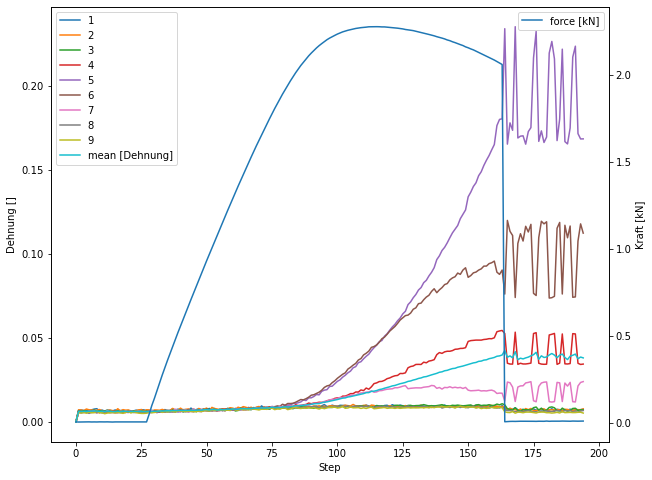

In [226]:
fig,ax=plt.subplots(figsize=(10,8))
ax1=ax.twinx()
for i in range(1,10):
    ax.plot(range(len(ap.index)),ap.iloc[:,i],label=i)
t=ax.plot(ap.mean(axis=1),label='mean [Dehnung]')


ax1.plot(force,label='force [kN]')
ax.legend()
ax1.legend()
ax1.set_ylabel('Kraft [kN]')
ax.set_ylabel('Dehnung []')
ax.set_xlabel('Step')
plt.show()
fig.savefig('test.png',dpi=500)

In [208]:

def get_full_df():
    return()